In [1]:
%reload_kedro

2022-01-07 15:20:47,245 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-01-07 15:20:47,277 - root - INFO - ** Kedro project Kedro Classification
2022-01-07 15:20:47,278 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-01-07 15:20:47,288 - root - INFO - Registered line magic `run_viz`


In [2]:
import numpy as np
import bisect
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.utils.validation import check_is_fitted
from pandas import DataFrame
from logging import getLogger
from sklearn.model_selection import train_test_split
from numpy import bincount
import matplotlib.pyplot as plt

class InductiveConformalPredictor():
    """
    Standard Conformal Predictor with uncertainty non-conformity score.
    Args:
        predictor: classifier used in upstream task.

    FROM: https://medium.com/data-from-the-trenches/measuring-models-uncertainty-with-conformal-prediction-f6aa8debb50e
    """

    def __init__(self, predictor):
        self.predictor = predictor
        check_is_fitted(self.predictor, attributes=["classes_"])

        self._le = LabelEncoder()
        self.classes = self._le.fit_transform(predictor.classes_)

    def fit(self, X, y):
        self.calibration_score = self._uncertainty_conformity_score(X)
        self.calibration_class = self._le.transform(y)
        return self

    def _uncertainty_conformity_score(self, data):
        uncertainty_score = 1 - self.predictor.predict_proba(data)
        return uncertainty_score

    def predict_proba(self, X, mondrian=True):
        check_is_fitted(self, attributes=["calibration_score"])

        conformity_score = self._uncertainty_conformity_score(X)
        conformal_pred = np.zeros(conformity_score.shape)

        for c in self.classes:
            if mondrian:
                calibration_filt = self.calibration_score[self.calibration_class == c]
                calib = calibration_filt[:, c]
            else:
                calib = self.calibration_score[range(len(self.calibration_class)), 
                                                          self.calibration_class]

            sorted_calib = np.sort(calib)
            conformal_pred[:, c] = [float(bisect.bisect(sorted_calib, x))/len(calib)
                                    for x in conformity_score[:, c]]

        return conformal_pred

    def predict(self, X, mondrian=True, alpha=0.05):
        _conformal_proba = self.predict_proba(X=X, mondrian=mondrian)
        conformal_pred = (_conformal_proba > alpha).astype(int)

        mlb = MultiLabelBinarizer()
        mlb.fit([self._le.classes_])
        pred = mlb.inverse_transform(conformal_pred)

        return pred

ALPHA = 0.25


def return_conformity_scores(
    data, params, model
) -> DataFrame:
    cfm = InductiveConformalPredictor(predictor=model)

    X, Y = data[params.get('features')], data[params.get('target')]

    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.20, random_state=42)

    cfm.fit(X_train, y_train)

    y_test_conf = cfm.predict(X, alpha=ALPHA)

    data = data.copy()

    data['y_test_conf'] = y_test_conf 
    
    return data

# Random Forest Classifier

In [3]:
data_test = catalog.load('scored_test')
model = catalog.load('model')

d2 = return_conformity_scores(data_test, context.params, model)

cats = d2.y_test_conf.unique()

print("Random Forest\n")
for cat in cats:
    d = d2[d2.y_test_conf == cat].copy()
    print("Mean: %4.2f -- Share: %3.1f%% -- Share Target: %3.1f%%" % (
        d.target.mean(), 100*(d.shape[0]/d2.shape[0]), 100*((d.target==1).sum()/(d2.target==1).sum())
    ))
    print("Bincount: %s" % bincount(d.target))
    print()

2022-01-07 15:20:48,187 - kedro.io.data_catalog - INFO - Loading data from `scored_test` (CSVDataSet)...
2022-01-07 15:20:48,250 - kedro.io.data_catalog - INFO - Loading data from `model` (PickleDataSet)...
Random Forest

Mean: 0.15 -- Share: 78.2% -- Share Target: 76.4%
Bincount: [2486  447]

Mean: 0.01 -- Share: 18.2% -- Share Target: 1.0%
Bincount: [675   6]

Mean: 0.97 -- Share: 3.6% -- Share Target: 22.6%
Bincount: [  4 132]



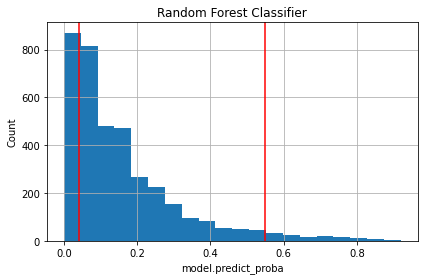

In [4]:
d2.prob.hist(bins=20)
plt.axvline((d2[d2.y_test_conf == (0,1)]).prob.min(), c='r')
plt.axvline((d2[d2.y_test_conf == (0,1)]).prob.max(), c='r')
plt.title("Random Forest Classifier")
plt.ylabel("Count")
plt.xlabel("model.predict_proba")
plt.tight_layout()
plt.show()

# Catboost Classifier

In [5]:
data_test = catalog.load('catboost.scored_test')
model = catalog.load('catboost.model')

d2 = return_conformity_scores(data_test, context.params, model)

cats = d2.y_test_conf.unique()

print("Catboost\n")
for cat in cats:
    d = d2[d2.y_test_conf == cat].copy()
    print("Mean: %4.2f -- Share: %3.1f%% -- Share Target: %3.1f%%" % (
        d.target.mean(), 100*(d.shape[0]/d2.shape[0]), 100*((d.target==1).sum()/(d2.target==1).sum())
    ))
    print("Bincount: %s" % bincount(d.target))
    print()

2022-01-07 15:20:48,658 - kedro.io.data_catalog - INFO - Loading data from `catboost.scored_test` (CSVDataSet)...
2022-01-07 15:20:48,712 - kedro.io.data_catalog - INFO - Loading data from `catboost.model` (PickleDataSet)...
Catboost

Mean: 0.15 -- Share: 74.5% -- Share Target: 73.7%
Bincount: [2364  431]

Mean: 0.02 -- Share: 21.1% -- Share Target: 2.1%
Bincount: [780  12]

Mean: 0.87 -- Share: 4.3% -- Share Target: 24.3%
Bincount: [ 21 142]



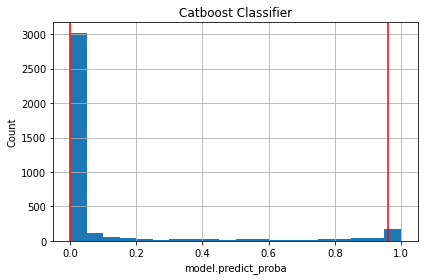

In [6]:
d2.prob.hist(bins=20)
plt.axvline((d2[d2.y_test_conf == (0,1)]).prob.min(), c='r')
plt.axvline((d2[d2.y_test_conf == (0,1)]).prob.max(), c='r')
plt.title("Catboost Classifier")
plt.ylabel("Count")
plt.xlabel("model.predict_proba")
plt.tight_layout()
plt.show()